In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Bidirectional, GRU, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [3]:
from google.colab import drive
drive.mount('/content/drive')

train_dataset_path = "/content/drive/My Drive/Image_classification/images/train"
validation_dataset_path = "/content/drive/My Drive/Image_classification/images/val"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
IMG_WIDTH = 75
IMG_HEIGHT = 75
BATCH_SIZE = 32

In [5]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 10704 images belonging to 11 classes.


In [6]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 2664 images belonging to 11 classes.


In [7]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : a
1 : button
2 : footer
3 : form
4 : h1
5 : h2
6 : h3
7 : h4
8 : header
9 : input
10 : textarea


In [8]:
# fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
# idx = 0

# for i in range(2):
#     for j in range(5):
#         label = labels[np.argmax(train_generator[0][1][idx])]
#         ax[i, j].set_title(f"{label}")
#         ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
#         ax[i, j].axis("off")
#         idx += 1

# plt.tight_layout()
# plt.suptitle("Sample Training Images", fontsize=21)
# plt.show()

In [9]:
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        # Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        # Activation('relu'),
        # MaxPooling2D(pool_size=(2, 2)),
        # BatchNormalization(),

        # Reshape((16, 16*32)),
        Reshape((16, 16*64)),
        # Reshape((10, 10*32)),
        # Reshape((7, 7*32)),
        # Reshape((35, 35*64)),
        # Reshape((23, 23*64)),
        # Bidirectional(GRU(64, activation='relu', return_sequences=True)),
        Bidirectional(GRU(128, activation='relu', return_sequences=True)),
        Flatten(),

        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=11, activation='softmax')
    ])

    return model

cnn_model = create_model()
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 71, 71, 128)       9728      
                                                                 
 activation (Activation)     (None, 71, 71, 128)       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 35, 35, 128)       0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 35, 35, 128)       512       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 33, 33, 64)        73792     
                                                                 
 activation_1 (Activation)   (None, 33, 33, 64)        0

In [10]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

In [11]:
optimizer = Adam(learning_rate=0.001)

In [12]:
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [13]:
history = cnn_model.fit(train_generator, epochs=50, validation_data=validation_generator,
                      #  verbose=2,
                       callbacks=[reduce_lr]
                        )

Epoch 1/50
335/335 [==============================] - 968s 3s/step - loss: 2.1071 - accuracy: 0.2378 - recall: 0.0159 - precision: 0.3250 - val_loss: 1.9748 - val_accuracy: 0.2774 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 0.0010
Epoch 2/50
335/335 [==============================] - 221s 661ms/step - loss: 1.9842 - accuracy: 0.2550 - recall: 0.0078 - precision: 0.4323 - val_loss: 2.0448 - val_accuracy: 0.2080 - val_recall: 0.0075 - val_precision: 0.8333 - lr: 0.0010
Epoch 3/50
335/335 [==============================] - 214s 640ms/step - loss: 1.9570 - accuracy: 0.2640 - recall: 0.0131 - precision: 0.4636 - val_loss: 1.9358 - val_accuracy: 0.2173 - val_recall: 0.0056 - val_precision: 0.6000 - lr: 0.0010
Epoch 4/50
335/335 [==============================] - 220s 656ms/step - loss: 1.9308 - accuracy: 0.2665 - recall: 0.0156 - precision: 0.5252 - val_loss: 1.9046 - val_accuracy: 0.2462 - val_recall: 0.0169 - val_precision: 0.7031 - lr: 0.0010
Epoch 5/50
335/335 [===========

In [14]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

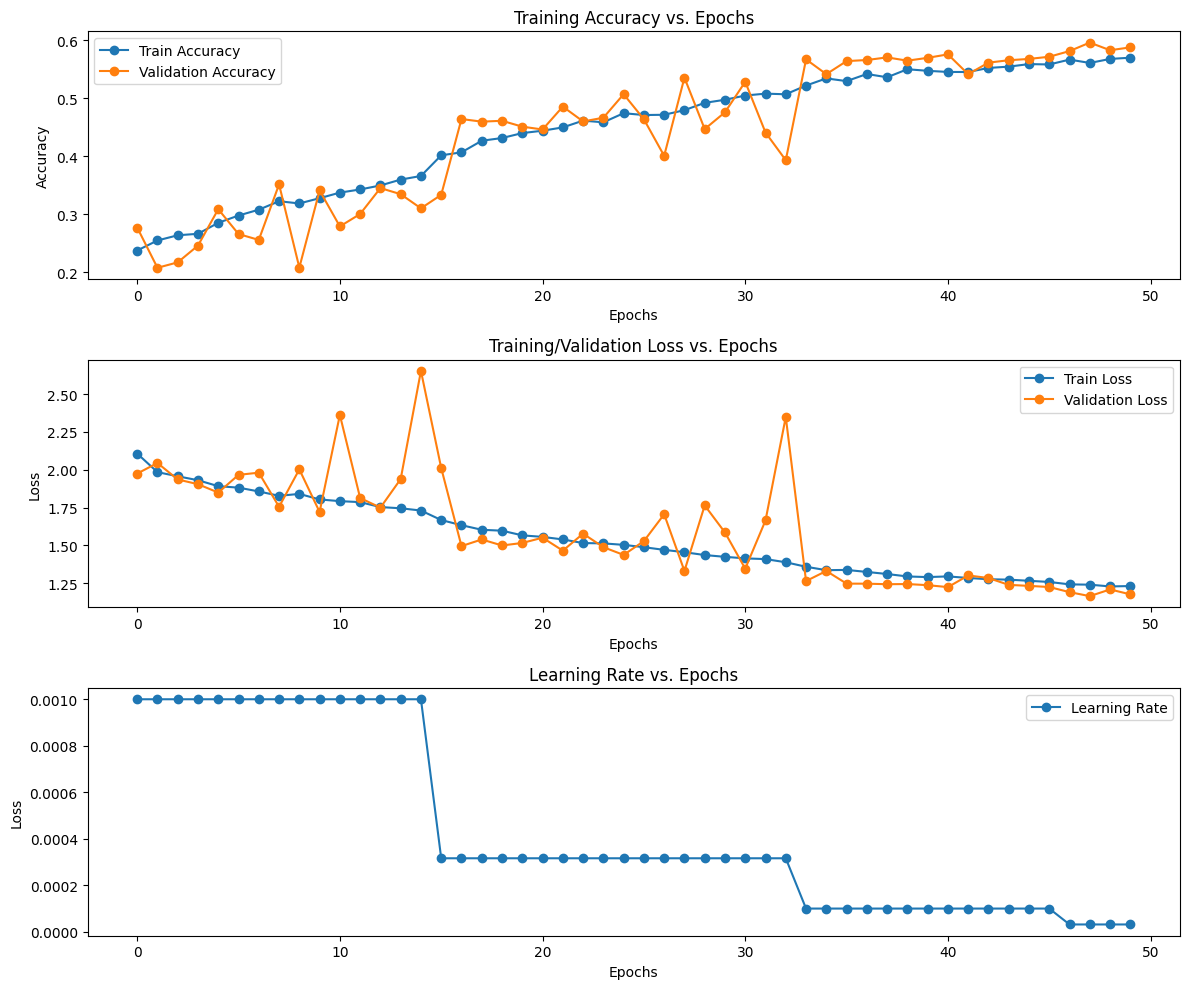

In [15]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [16]:
test_dataset = "/content/drive/My Drive/Image_classification/images/val"

In [17]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 2664 images belonging to 11 classes.


In [18]:
predictions = cnn_model.predict(test_generator)

84/84 [==============================] - 36s 421ms/step


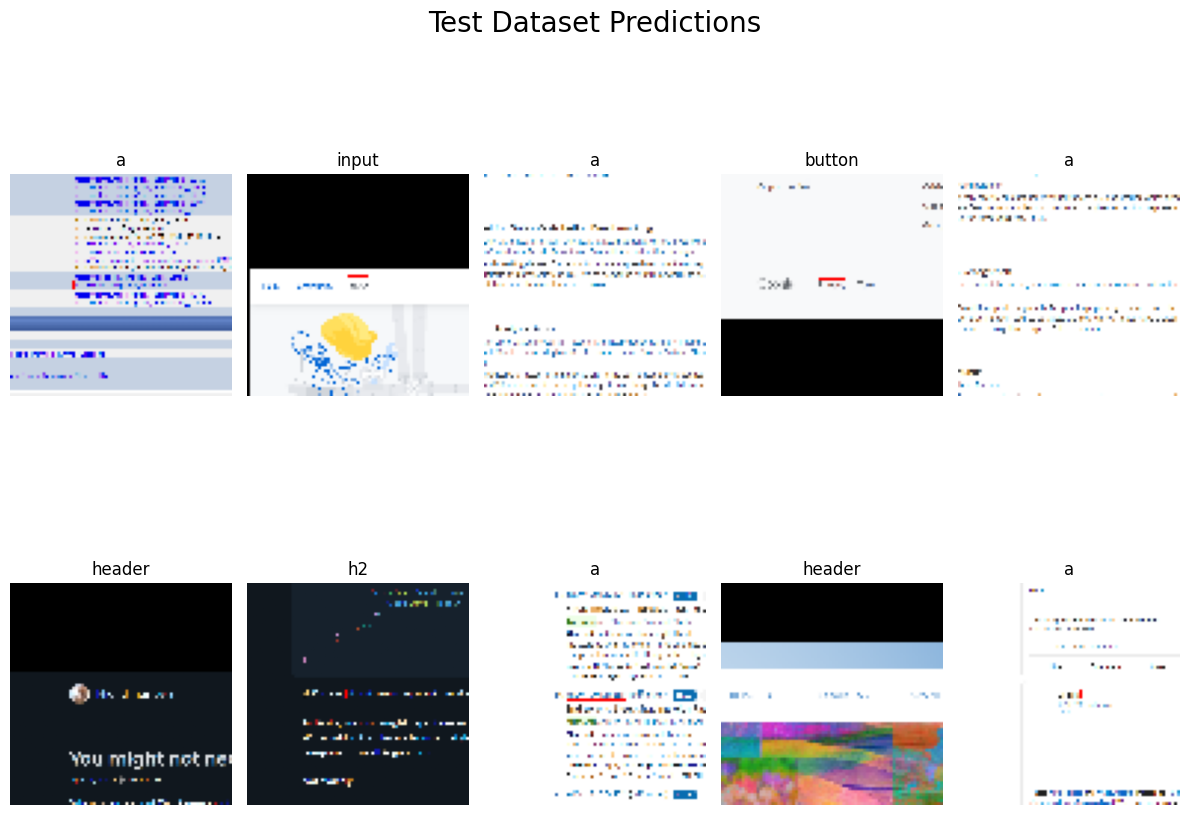

In [19]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [20]:
test_loss, test_accuracy, *is_anything_else_being_returned = cnn_model.evaluate(test_generator, batch_size=BATCH_SIZE)

84/84 [==============================] - 35s 422ms/step - loss: 1.1761 - accuracy: 0.5878 - recall: 0.4230 - precision: 0.7724


In [21]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     1.176056981086731
Test Accuracy: 0.587837815284729


In [22]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

In [23]:
cf_mtx = confusion_matrix(y_true, y_pred)
print(cf_mtx.size)
print(cf_mtx)
group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
print(len(group_counts))

121
[[209  58   7   0   2  50  65   1   2  18   0]
 [ 14 416   9   4   0  31  44   0   0  13   0]
 [  5   2  27   0   0   5   0   0   0   0   0]
 [  4   9   1   9   1  14   8   1  12  28   0]
 [  1   3   0   0   6  55   7   3   9  11   0]
 [  7  18   0   0   1 308  91   7   2   9   0]
 [ 27  15   2   0   0 127 343   2   1   4   0]
 [  1   5   1   0   0  58  69  39   0   0   0]
 [  1   2   1   1   0  42   4   0  50   6   0]
 [ 12  25   0   2   0  32  14   0  10 159   0]
 [  0   0   0   0   0   2   0   0   0   0   0]]
121


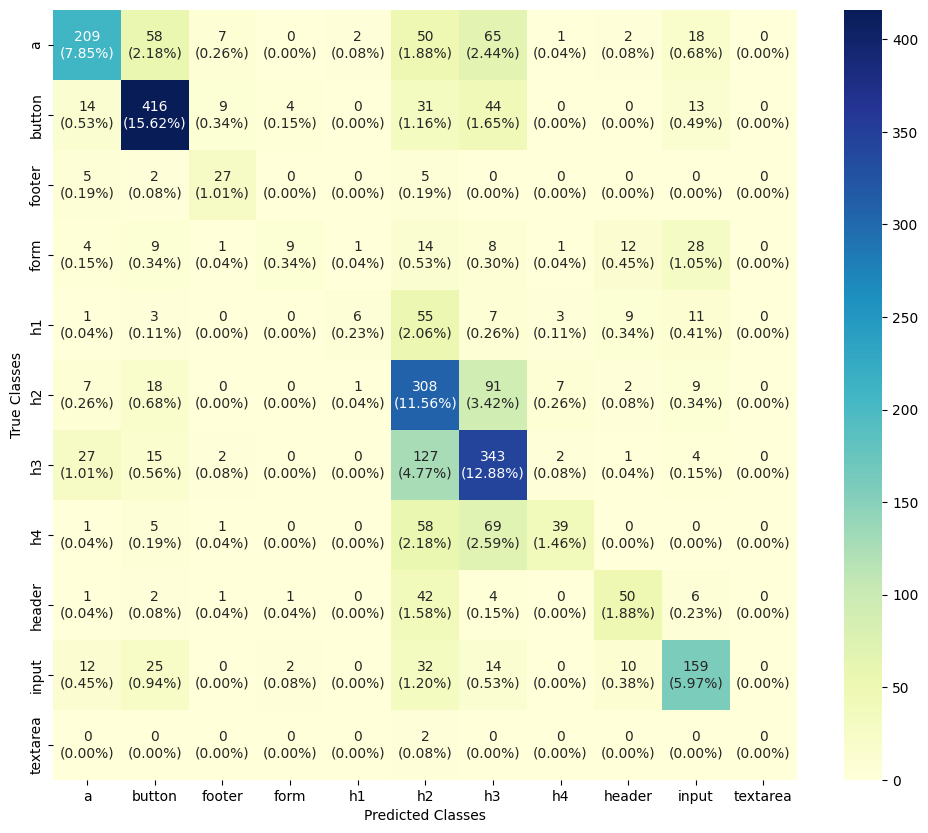

In [24]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(11, 11)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [25]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

           a       0.74      0.51      0.60       412
      button       0.75      0.78      0.77       531
      footer       0.56      0.69      0.62        39
        form       0.56      0.10      0.17        87
          h1       0.60      0.06      0.11        95
          h2       0.43      0.70      0.53       443
          h3       0.53      0.66      0.59       521
          h4       0.74      0.23      0.35       173
      header       0.58      0.47      0.52       107
       input       0.64      0.63      0.63       254
    textarea       0.00      0.00      0.00         2

    accuracy                           0.59      2664
   macro avg       0.56      0.44      0.44      2664
weighted avg       0.62      0.59      0.57      2664



In [26]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [27]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

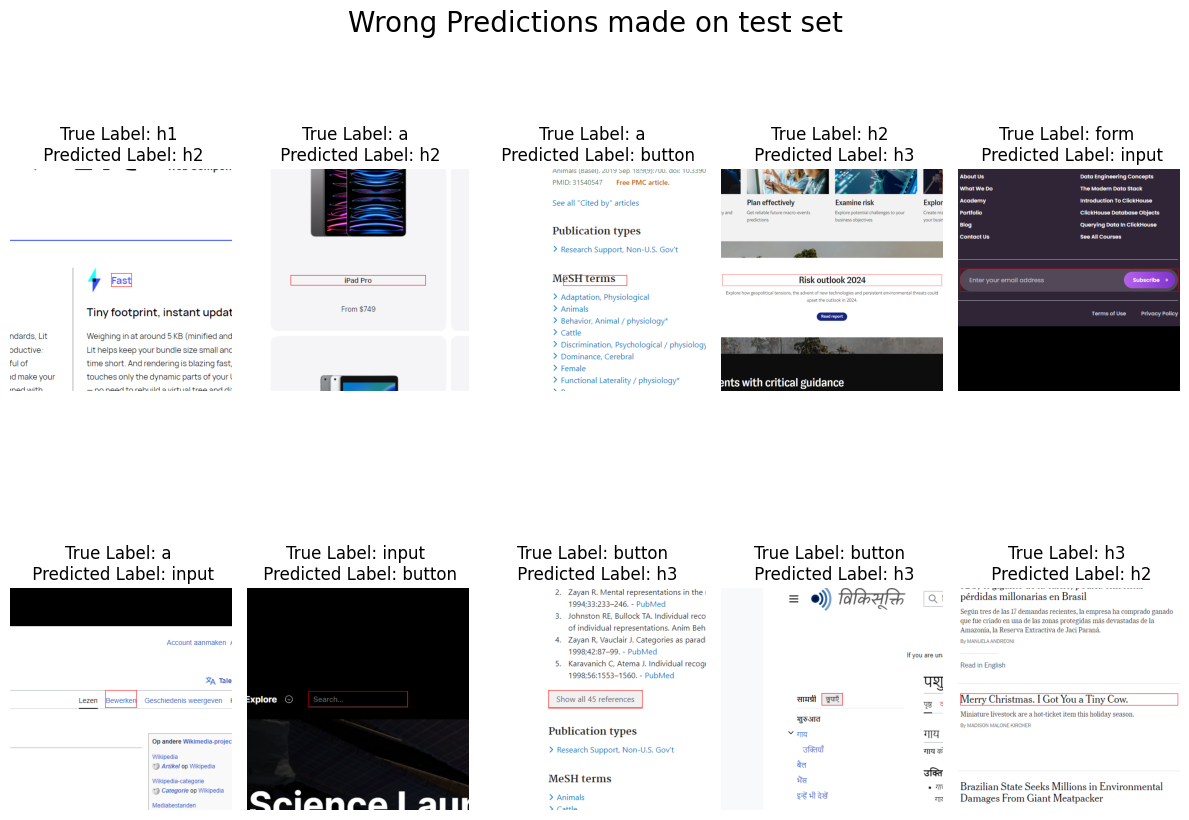

In [28]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        img_path = os.path.join(test_dataset, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()

In [29]:
import datetime
nowtime = f"{datetime.datetime.now()}".split('.')[0]

In [30]:
model_path = f"/content/drive/My Drive/Image_classification/models/model_{test_accuracy*100:.2f}_{nowtime}.h5"

In [31]:
cnn_model.save(model_path)

In [32]:
test_accuracy*100

58.7837815284729